In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [19]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import numpy as np

import sys 
sys.path.append('../')
import Utils.utils as util
from importlib import reload
reload(util)

from sklearn.linear_model import Lasso
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize

np.set_printoptions(threshold=np.inf) #print full arrays
from sklearn import linear_model

In [20]:
def split_patch(patch):
    h = patch.shape[0]
    #Convert one patch into a column vector for training
    patch = patch.flatten()
    pixel_central = patch[(h*(h//2)+(h//2))*3:(h*(h//2)+(h//2))*3+3]
    patch_sans_central = np.delete(patch, range((h*(h//2)+(h//2))*3, (h*(h//2)+(h//2))*3+3))
    return np.array((patch_sans_central, pixel_central))
    
def convert_patch_into_vector(patch):
    #Convert one patch into a column vector for training
    #patch = patch.flatten()
    h = patch.shape[0]
    patch = np.reshape(patch, h*h*3)
    return np.array(patch)

def convert_vector_into_patch(vector, h):
    #Convert a one column vector into a patch of size h
    return vector.reshape((h,h,7))
    
def convert_patches_into_training_set(patches):
    #Convert a set of patches into a set of vectors
    return np.array(list(map(convert_patch_into_vector, patches))).T

def find_index_noisy_lines(label):
    """
    indexes = []
    for index, value in enumerate(label):
        if(value == -1):
            indexes.append(index)
    """
    label = np.array(label)
    indexes = np.where(label < 0)
    return indexes

def delete_all_indexes_from(dictionary, label):
    indexes = find_index_noisy_lines(label)
    dictionary = np.delete(dictionary, indexes , 0)
    label = np.delete(label, indexes , 0)
    
    return (dictionary, label)    

def inpaint_image(noisy_image, dictionary, coord_noisy_pix, h, clear_image):
    noisy_image_orig = np.array(noisy_image)
    
    #todo question: vérifier qu'il faut bien faire le lassocv pour trouver le alpha sur le clear?
        
    lassocv = linear_model.LassoCV()
    y, x = coord_noisy_pix[0]
    label = util.get_patch(x, y, h, noisy_image)
    label = list(convert_patch_into_vector(label))
    #lassocv.fit(dictionary, label)
    #alpha_ = lassocv.alpha_
    
    alpha_ = 0.01
    
    print("alpha = ", alpha_)
    dictionary_full = np.array(dictionary)
       
    i = 0
    nbiter  = len(coord_noisy_pix)
    for y, x in coord_noisy_pix:
        if(i%10==0): print( i, " / ", nbiter)
        i = i + 1
        
        #print("Correction de x : ", x, " et y : ", y)
        patch = util.get_patch(x, y, h, noisy_image)
        label = list(convert_patch_into_vector(patch))
        
        dictionary = np.array(dictionary_full)
        dictionary, label = delete_all_indexes_from(dictionary,label)

        #print("--- lasso regression ---")
        
        model = Lasso(fit_intercept=True,alpha=alpha_,positive=True)
        
        model.fit(dictionary, label)
        
        res = model.predict(dictionary_full)
        newPixel = util.get_centered_pixel(res, h)

        
        """
        coef = model.coef_.reshape((1,-1)) #poids
        sparse_coef_ = model.sparse_coef_
    
        print(sparse_coef_)
        print("coef shape : ", coef.shape)
        #print("sparse_coef_ shape : ", sparse_coef_.shape)
        print("nb patch not at zero: ", np.count_nonzero(sparse_coef_.toarray()), " / ", coef.shape[1])
        print("dictionary shape : ", dictionary_full.shape) 
        
        normalized_coefs = normalize(coef, norm='l1')
        #print("normalized_coefs shape = ", normalized_coefs)
        print("sum(normalized_coefs) = ", np.sum(normalized_coefs, axis=1))
        
        res = normalized_coefs*dictionary_full
        print("coef*dictionary shape= ",res.shape)
        
        resflat = np.sum(normalized_coefs*dictionary,axis=1)
        #print("resflat = ",resflat)
        
        print("sum(normalized_coefs*dictionary,axis=1) shape= ", resflat.shape)
        
        newPixel = util.get_centered_pixel(resflat, h)
        print("nouveau pixel : ", newPixel)
        print("")
        """
        #print(newPixel)
        noisy_image[x][y] = newPixel
        
        
        #util.display_im(noisy_image) #pour afficher toutes les images

    util.display_im(noisy_image_orig)
    util.display_im(noisy_image)

taille de l'image :  (143, 128, 3)
128  ,  143
nbnoisy: 171 ,   nbclear: 1964


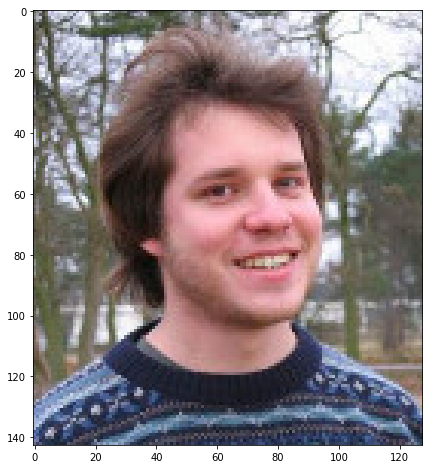

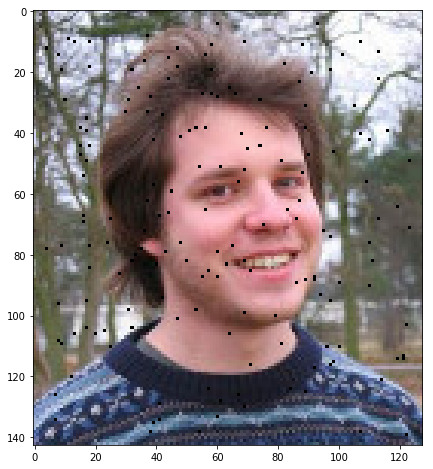

In [21]:
%matplotlib inline
img_matrice = util.read_im("Data/imgdataset/12.jpg")

print("taille de l'image : ", img_matrice.shape)

util.display_im(img_matrice)

#Taille des patchs
h=3 #nombre impair

#noisy_image, deletepixels = util.delete_rect(img_matrice, 100, 100, 31, 31)
#display_im(noisy_image)

width = img_matrice.shape[1]
height = img_matrice.shape[0]

print(width," , ", height)

noisy_image, noise_pixels = util.noise(img_matrice, 0.01, width, height, h)

#noise_pixels = np.concatenate((np.array(noise_pixels), np.array(deletepixels)), axis=0)
util.display_im(noisy_image)

_,clear_patches = util.get_patches(noisy_image, h, width, height)
noisy_patches,_ = util.get_all_patches(noisy_image, h, width, height)

nbnoisy = np.shape(noisy_patches)[0]
nbclear = np.shape(clear_patches)[0]
print("nbnoisy:", nbnoisy, ",   nbclear:", nbclear)

In [22]:
training = convert_patches_into_training_set(clear_patches)
print(training.shape)

(27, 1964)


alpha =  0.01
0  /  171


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10  /  171
20  /  171
30  /  171
40  /  171
50  /  171
60  /  171
70  /  171
80  /  171
90  /  171
100  /  171
110  /  171
120  /  171
130  /  171
140  /  171
150  /  171
160  /  171
170  /  171


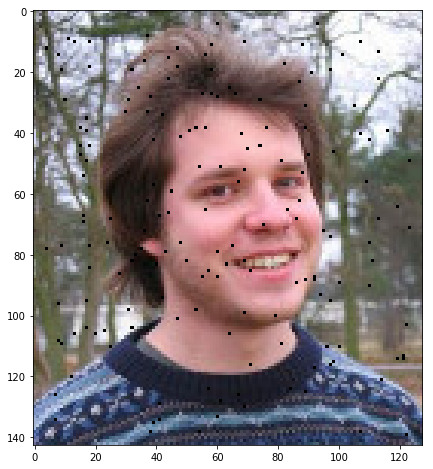

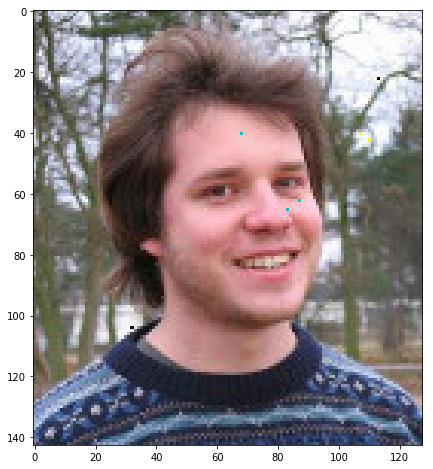

In [23]:
inpaint_image(noisy_image, training, noise_pixels, h, img_matrice)

In [24]:
noisy_image, deletepixels = util.delete_rect(img_matrice, 100, 100, 31, 31)

In [25]:
noisy_image

array([[[105, 113,  89],
        [132, 133, 137],
        [159, 156, 165],
        [ 70,  71,  57],
        [112, 112, 102],
        [218, 216, 240],
        [184, 184, 222],
        [225, 230, 252],
        [224, 227, 242],
        [240, 244, 255],
        [237, 241, 250],
        [182, 189, 197],
        [189, 195, 207],
        [210, 216, 232],
        [157, 163, 177],
        [226, 232, 244],
        [224, 226, 249],
        [168, 171, 190],
        [137, 139, 151],
        [126, 129, 136],
        [189, 192, 197],
        [213, 218, 224],
        [239, 245, 255],
        [225, 233, 246],
        [232, 239, 249],
        [143, 150, 158],
        [105, 110, 116],
        [106, 112, 110],
        [ 92,  99,  91],
        [106, 113, 105],
        [117, 121, 120],
        [ 66,  69,  74],
        [ 81,  85,  94],
        [ 93,  95, 110],
        [124, 122, 143],
        [157, 154, 173],
        [157, 154, 163],
        [ 93,  91,  92],
        [ 58,  59,  53],
        [ 54,  55,  47],
